In [1]:
%pip install pyramid-arima;

In [2]:
#Check Version
import statsmodels._version
if statsmodels._version.get_versions()['version'] != '0.11.1':
  !pip install --upgrade statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data"

df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS' # Month Start

df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D' # Month Start
df2 = df2[:120]

df3 = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)
df3.index.freq = 'MS'

/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data


In [3]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults


In [4]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#**ARMA**

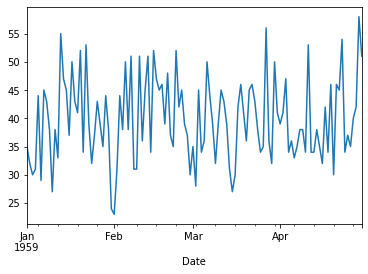

In [5]:
df2['Births'].plot()

### Function for running the augmented Dickey-Fuller test
Since we'll use it frequently in the upcoming forecasts, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    print('\nResult:')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
adf_test(df2['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


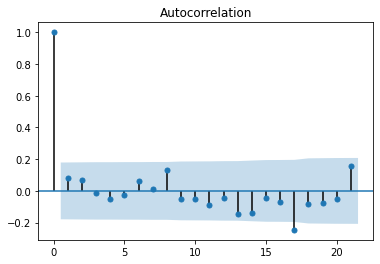

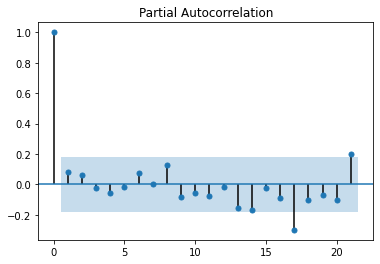

In [8]:
plot_acf(df2['Births'])
plot_pacf(df2['Births']);

In [9]:
from pyramid.arima import auto_arima

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1959-01-01 to 1959-04-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  120 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


In [19]:
auto_arima(df2['Births'],trace=True,seasonal=False,maxiter=1000).summary()

Fit ARIMA: order=(2, 0, 2); AIC=829.481, BIC=846.206, Fit time=0.205 seconds
Fit ARIMA: order=(0, 0, 0); AIC=823.489, BIC=829.064, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0); AIC=824.647, BIC=833.010, Fit time=0.022 seconds
Fit ARIMA: order=(0, 0, 1); AIC=824.747, BIC=833.110, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 1); AIC=826.399, BIC=837.549, Fit time=0.062 seconds
Total fit time: 0.319 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 0)   Log Likelihood                -409.745
Method:                           css   S.D. of innovations              7.357
Date:                Wed, 01 Jul 2020   AIC                            823.489
Time:                        02:48:47   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7833      0.672     59.240      0.000      38.467      41.100
==============================================================================
"""

In [20]:
help(auto_arima)

Help on function auto_arima in module pyramid.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=10, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ch', stepwise=True, n_jobs=1, start_params=None, trend='c', method=None, transparams=True, solver='lbfgs', maxiter=50, disp=0, callback=None, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The ``auto_arima`` function seeks to identify the most optimal
    parameters for an ``ARIMA`` model, and returns a fitted ARIMA model. This
    function is based on the commonly-used R function,
    ``forecast::auto

In [21]:
#train test split
train = df2.iloc[:90]
test = df2.iloc[90:]

In [22]:
model = ARMA(train['Births'],order = (2,2)).fit()

In [23]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Wed, 01 Jul 2020   AIC                            627.809
Time:                        02:48:53   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.608      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.67

In [24]:
start = len(train)
end = len(train) + len(test) - 1

In [25]:
prediction2 = model.predict(start,end).rename('ARMA(2,2) Predictions')

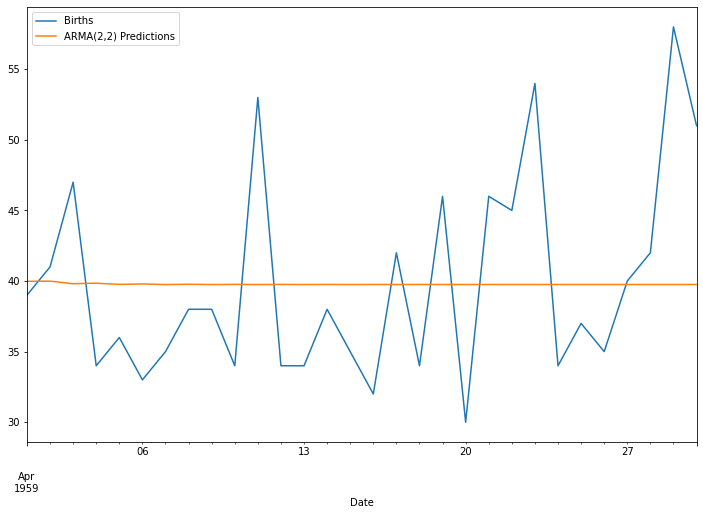

In [26]:
test.plot(legend = True,figsize=(12,8))
prediction2.plot(legend = True)


In [27]:
stepwise_fit = auto_arima(df2['Births'],start_p=0,start_q=0,max_p=6,max_q=3,seasonal=False,trace=True)#trace will show the grid search

Fit ARIMA: order=(0, 0, 0); AIC=823.489, BIC=829.064, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0); AIC=824.647, BIC=833.010, Fit time=0.025 seconds
Fit ARIMA: order=(0, 0, 1); AIC=824.747, BIC=833.110, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 1); AIC=826.399, BIC=837.549, Fit time=0.067 seconds
Total fit time: 0.122 seconds


In [28]:
print(stepwise_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 0)   Log Likelihood                -409.745
Method:                           css   S.D. of innovations              7.357
Date:                Wed, 01 Jul 2020   AIC                            823.489
Time:                        02:48:58   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7833      0.672     59.240      0.000      38.467      41.100


#ARIMA

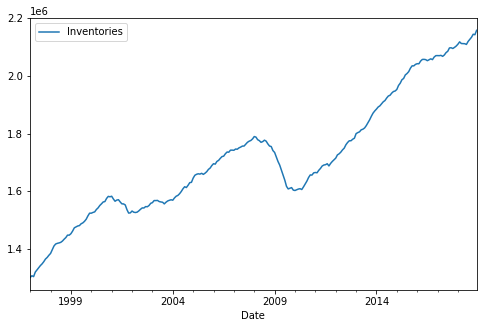

In [29]:
df3.plot(figsize=(8,5))

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

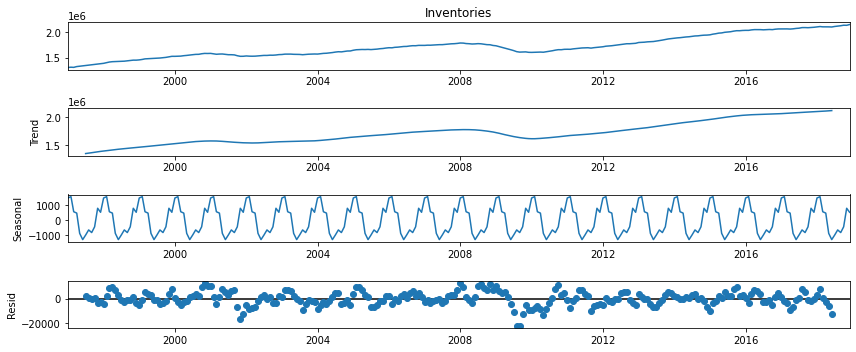

In [31]:
result = seasonal_decompose(df3['Inventories'],model='add')

from pylab import rcParams
rcParams['figure.figsize']  = 12, 5

result.plot();

In [34]:
print(auto_arima(df3['Inventories'],seasonal=False,trace=True).summary())

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.090 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.110 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.527, BIC=5247.388, Fit time=0.284 seconds
Fit ARIMA: order=(3, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.119 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.325, BIC=5247.186, Fit time=0.092 seconds
Total fit time: 0.823 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. o

In [35]:
from statsmodels.tsa.statespace.tools import diff

In [36]:
df3['Diff_1'] = diff(df3['Inventories'],k_diff=1)

In [37]:
adf_test(df3['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [38]:
df3['Diff_1'][1:]


Date
1997-02-01     5919.0
1997-03-01    -3102.0
1997-04-01    15762.0
1997-05-01     7554.0
1997-06-01     7394.0
               ...   
2018-08-01     7552.0
2018-09-01     7002.0
2018-10-01    10467.0
2018-11-01    -1638.0
2018-12-01    15114.0
Freq: MS, Name: Diff_1, Length: 263, dtype: float64

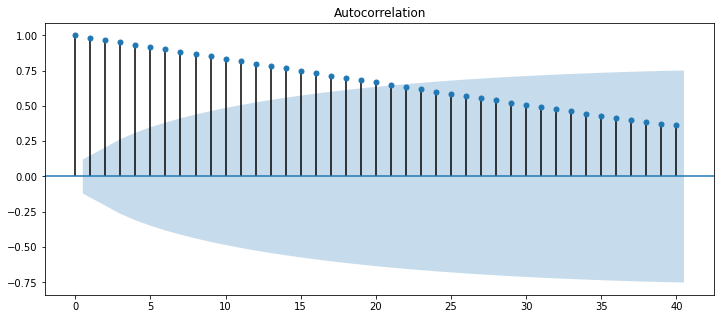

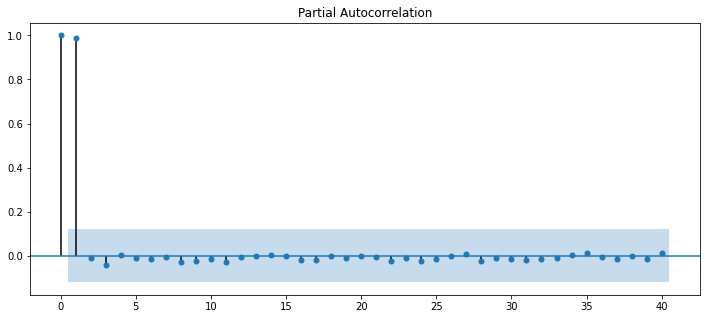

In [39]:
plot_acf(df3['Inventories'],lags = 40);
plot_pacf(df3['Inventories'],lags = 40);

#According to literature:

AR: 1

MA: 0 or 1

I:  1

In [42]:
stepwise_fit = auto_arima(df3['Inventories'],seasonal=False,trace=True,start_p=0,start_q=0, max_p=2,max_q=2)

print(stepwise_fit.summary())


Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.075 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.096 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.527, BIC=5247.388, Fit time=0.302 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.115 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.325, BIC=5247.186, Fit time=0.083 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.784 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Wed, 01 Jul 2

In [43]:
len(df3)

264

In [44]:
train = df3.iloc[:252]
test = df3.iloc[252:]

In [71]:
model = ARIMA(train['Inventories'],order=(1,1,1)).fit()

In [72]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Wed, 01 Jul 2020   AIC                           4980.790
Time:                        03:06:41   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.6171   1344.919      2.378      0.017     561.625    5833.610
ar.L1.D.Inventories     0.9026      0.039     23.013      0.000       0.826       0.979
ma.L1.D.Inventor

In [73]:
predictions = model.predict(start=len(train),end=len(train)+len(test)-1,typ = 'levels').rename('ARIMA(1,1,1)')

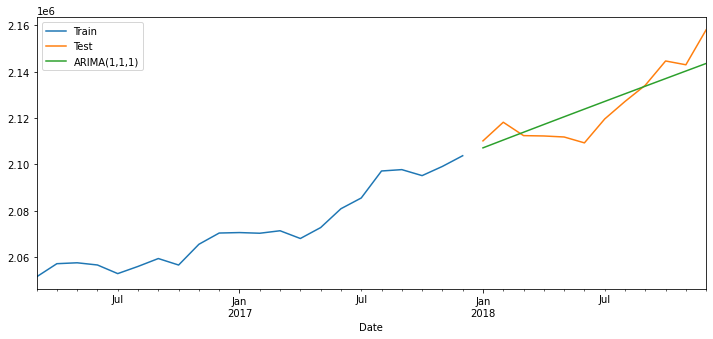

In [88]:
#train.plot()
train['Inventories'].iloc[230:].plot(legend=True,label = 'Train')
test['Inventories'].plot(legend=True,label = "Test")
predictions.plot(legend=True)


In [75]:
from statsmodels.tools.eval_measures import rmse

In [76]:
error = rmse(test['Inventories'],predictions)

In [77]:
print(error)
print(test['Inventories'].mean())

7789.561238050531
2125075.6666666665


Forecast into unkown future

In [80]:
model = ARIMA(df3['Inventories'],order=(1,1,1)).fit()
prediction = model.predict(start=len(df3),end=len(df3)+12,typ='levels').rename("ARIMA (1,1,1)")

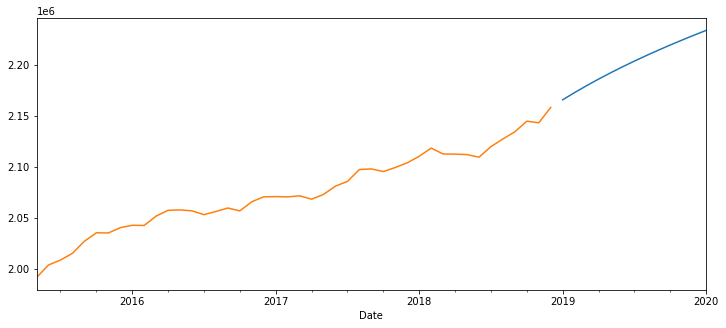

In [91]:
prediction.plot()
df3['Inventories'].iloc[220:].plot()

#SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX